1. Take image and Label them

In [ ]:
! pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentation

In [2]:
import os
import time
import cv2 as cv
import uuid #unique uniform identifer(create unique file name)

In [2]:
img_path = os.path.join('data', 'image')
number_img = 30

In [ ]:
cap = cv.VideoCapture(0)
for imgnum in range(number_img):
    print("Collecting image{}".format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(img_path, f'{str(uuid.uuid1())}.jpg')
    cv.imwrite(imgname, frame)
    cv.imshow('frame', frame)
    time.sleep(0.5)

    if cv.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv.destroyAllWindows()

2. review Datasets Build Image loading Function

In [3]:
import tensorflow as tf
import numpy as np
import json as js
from  matplotlib import pyplot as plt

In [5]:
gpus = tf.config.experimental.list_logical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
tf.config.list_logical_devices('GPU')

In [7]:
image = tf.data.Dataset.list_files('data\\image\\*.jpg', shuffle=False)

In [14]:
def load_img(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [15]:
image = image.map(load_img)

In [ ]:
image.as_numpy_iterator().next()

In [ ]:
type(image)

In [19]:
image_generator = image.batch(4).as_numpy_iterator()
plot_img = image_generator.next()

In [ ]:
fig, ax = plt.subplots(ncols = 4, figsize=(20,20))
for idx, images in enumerate(plot_img):
    ax[idx].imshow(images)
plt.show()

In [39]:
for folder in ['train','test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'image')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data', 'label', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'label', filename)
            os.replace(existing_filepath, new_filepath)

4. Apply image augmnetation on images and label using albumentation

In [7]:
import albumentations as alb

In [8]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                         bbox_params = alb.BboxParams(format='albumentations',
                                                      label_fields=['class_labels'])
                         )
            

In [9]:
img = cv.imread(os.path.join('data','train','image','image_0.jpg'))

In [10]:
with open(os.path.join('data','train','label','image_0.json'),'r')as f:
    label = js.load(f)

In [11]:
label['shapes'][0]['points']

[[182.5, 179.42307692307696], [369.0384615384615, 360.19230769230774]]

In [12]:
coords = [0,0,0,0]
coords[0]=label['shapes'][0]['points'][0][0]
coords[1]=label['shapes'][0]['points'][0][1]
coords[2]=label['shapes'][0]['points'][1][0]
coords[3]=label['shapes'][0]['points'][1][1]

In [13]:
coords = list(np.divide(coords, [640,480,640,480]))

In [14]:
coords

[0.28515625, 0.373798076923077, 0.576622596153846, 0.7504006410256411]

In [15]:
augmented = augmentor(image=img, bboxes= [coords], class_labels = ['face'])

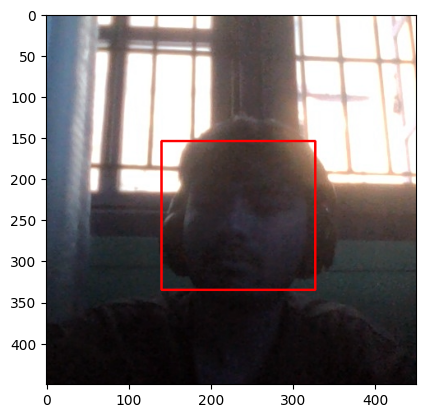

In [16]:
cv.rectangle(augmented['image'], 
            tuple(np.multiply(augmented['bboxes'][0][:2],[450,450]).astype(int)),
            tuple(np.multiply(augmented['bboxes'][0][2:],[450,450]).astype(int)),
            (255,0,0), 2)

plt.imshow(augmented['image'])


5. Bulid and Run augmentation

In [ ]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'image')):
        img = cv.imread(os.path.join('data', partition, 'image', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'label', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = js.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv.imwrite(os.path.join('aug_data', partition, 'image', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    js.dump(annotation, f)

        except Exception as e:
            print(e)
            

In [ ]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\image\\*.jpg', shuffle=False)
train_images = train_images.map(load_img)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [ ]:

test_images = tf.data.Dataset.list_files('aug_data\\test\\image\\*.jpg', shuffle=False)
test_images = test_images.map(load_img)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [ ]:

val_images = tf.data.Dataset.list_files('aug_data\\val\\image\\*.jpg', shuffle=False)
val_images = val_images.map(load_img)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

6. Preapre Labels

In [ ]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']


In [ ]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

train_labels.as_numpy_iterator().next()

7. Combine label and Image samples

In [ ]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

In [ ]:

train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [ ]:

test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [ ]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [ ]:

train.as_numpy_iterator().next()[1]

In [ ]:
data_samples = train.as_numpy_iterator()

In [ ]:

res = data_samples.next()

In [ ]:

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

8.Import layers ans base Network

In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [ ]:

vgg = VGG16(include_top=False)

In [ ]:
vgg.summary()

In [ ]:

def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [ ]:

facetracker = build_model()

In [ ]:

facetracker.summary()

In [ ]:

X, y = train.as_numpy_iterator().next()

In [ ]:

X.shape

In [ ]:

classes, coords = facetracker.predict(X)

In [ ]:

classes, coords

9. Define Losses and Optimizer

In [ ]:

batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [ ]:

opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [ ]:
#Create Localization Loss and Classification Loss
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [ ]:

classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [ ]:
localization_loss(y[1], coords)

In [ ]:
classloss(y[0], classes)

In [ ]:
regressloss(y[1], coords)

10. Train NN

In [ ]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [ ]:
model = FaceTracker(facetracker)

In [ ]:
model.compile(opt, classloss, regressloss)


In [ ]:
logdir='logs'

In [ ]:

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


In [ ]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

In [ ]:
hist.history

In [ ]:
#Plot Performance
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

11. make prediction

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [ ]:
yhat = facetracker.predict(test_sample[0])

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
facetracker.save('facetracker.h5')

In [ ]:
#Real Time Detection
cap = cv.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv.LINE_AA)
    
    cv.imshow('EyeTrack', frame)
    
    if cv.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv.destroyAllWindows()